# Exercise 9.2 - Solution
Large arrays of radio antennas can be used to measure cosmic rays by recording the electromagnetic radiation generated in the atmosphere.
These radio signals are strongly contaminated by galactic noise as well as signals from human origin. Since these signals appear to be similar to the background, the discovery of cosmic-ray events can be challenging.
## Identification of signals
In this exercise, we design an RNN to classify if the recorded radio signals contain a cosmic-ray event or only noise.

The signal-to-noise ratio (SNR) of a measured trace $S(t)$ is defined as follows:

$$\mathrm{SNR}=\frac{S^{\mathrm{signal}}(t)_\mathrm{max}}{\mathrm{RMS}[S(t)]},$$  
where $S^{\mathrm{signal}}(t)_\mathrm{max}$ denotes the maximum amplitude of the (true) signal.

Typical cosmic-ray observatories enable a precise reconstruction at an SNR of roughly 3.

We choose a challenging setup in this task and try to identify cosmic-ray events in signal traces with an SNR of 2.  
Training RNNs can be computationally demanding, thus, we recommend to use a GPU for this task.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

layers = keras.layers
print("keras", keras.__version__)

keras 2.6.0


### Load and prepare dataset
In this task, we use a simulation of cosmic-ray-induced air showers that are measured by radion antennas.  
For more information, see https://arxiv.org/abs/1901.04079.  
The task is to design an RNN which is able to identify if the measured signal traces (shortened to 500 time steps) contains a signal or not.

In [2]:
import os
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1R-qfxO1jVh88TC9Gnm9JGMomSRg0Zpkx"
output = 'radio_data.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

f = np.load(output)
n_train = 40000

x_train, x_test = f["traces"][:n_train], f["traces"][n_train:]  # measured traces (signal + colored noise)
signals = f["signals"]  # signal part (only available for cosmic-ray events)

labels = (signals.std(axis=-1) != 0).astype(float)  # define training label (1=cosmic event, 0=noise)
y_train, y_test = labels[:n_train], labels[n_train:]

## Plot example signal traces
Left: signal trace containing a cosmic-ray event. The underlying cosmic-ray signal is shown in red, the backgrounds + signal is shown in blue.
Right: background noise.

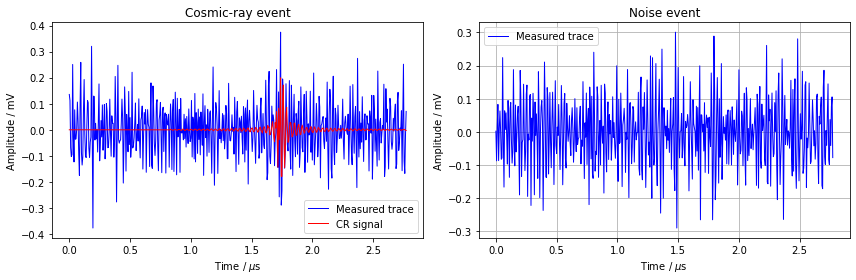

In [3]:
from matplotlib import pyplot as plt
fs = 180e6  # Sampling frequency of antenna setup 180 MHz
t = np.arange(500) / fs * 1e6
idx = np.random.randint(0, labels.sum()-1)
idx2 =  np.random.randint(0, n_train - labels.sum())

plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, np.real(f["traces"][labels.astype(bool)][idx]), linewidth = 1, color="b", label="Measured trace")
plt.plot(t, np.real(signals[labels.astype(bool)][idx]), linewidth = 1, color="r", label="CR signal")
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Cosmic-ray event")
plt.subplot(1, 2, 2)

plt.plot(t, np.real(x_train[~y_train.astype(bool)][idx2]), linewidth = 1, color="b", label="Measured trace")
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Noise event")

plt.grid(True)
plt.tight_layout()

In [4]:
sigma = x_train.std()
x_train /= sigma
x_test /= sigma

To avoid that the model learns unphysical features (e.g. specific floating point amplitude values) we add some (physically insignificant) random noise to the data as a `GaussianNoise` layer:

In [5]:
noise_layer = layers.GaussianNoise(0.01)

In [6]:
def overlay_w_wo_noise():
    fig, ax = plt.subplots(figsize=(20, 5))
    xi = x_train[idx2:idx2+1]
    ax.plot(xi.squeeze(), label="Original")
    ax.plot(noise_layer(xi).numpy().squeeze(), label="With 0.01 Gaussian noise addeed")
    ax.legend()
    return ax

2023-02-01 13:58:54.456860: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 13:58:55.208666: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-01 13:58:55.208707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


<AxesSubplot:>

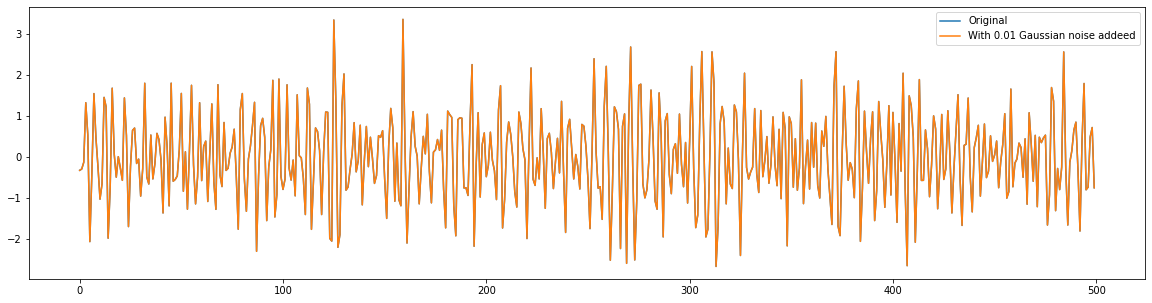

In [7]:
overlay_w_wo_noise()

Zoom in:

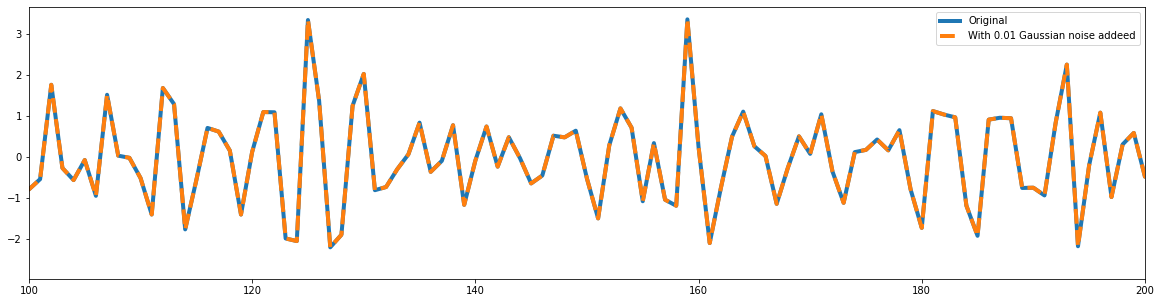

In [8]:
ax = overlay_w_wo_noise()
ax.set_xlim(100, 200)
ax.lines[0].set_linewidth(4)
ax.lines[1].set_linewidth(4)
ax.lines[1].set_linestyle("--")
ax.legend()

### Define RNN model
In the following, design a cosmic-ray model to identify cosmic-ray events using an RNN-based classifier.

In [9]:
model = keras.models.Sequential()
model.add(layers.Input((500, 1)))
model.add(noise_layer)
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(10, return_sequences=True)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 500, 1)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 64)           8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 128)          66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 20)           11120     
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

#### Pre-processing of data and RNN training

In [10]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-3, decay=0.00008),
    metrics=['accuracy'])


results = model.fit(x_train[...,np.newaxis], y_train,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_split=0.1,
                    callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-5),
                                 keras.callbacks.EarlyStopping(patience=15, verbose=1)]
                    )

2023-02-01 13:58:57.606883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-02-01 13:59:03.775793: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


282/282 [==============================] - 41s 121ms/step - loss: 0.6100 - accuracy: 0.6570 - val_loss: 0.6138 - val_accuracy: 0.6515
Epoch 2/100
282/282 [==============================] - 33s 116ms/step - loss: 0.5890 - accuracy: 0.6816 - val_loss: 0.5807 - val_accuracy: 0.6837
Epoch 3/100
282/282 [==============================] - 34s 121ms/step - loss: 0.5871 - accuracy: 0.6835 - val_loss: 0.5826 - val_accuracy: 0.6850
Epoch 4/100
282/282 [==============================] - 34s 122ms/step - loss: 0.5863 - accuracy: 0.6869 - val_loss: 0.5792 - val_accuracy: 0.6862
Epoch 5/100
282/282 [==============================] - 34s 122ms/step - loss: 0.5839 - accuracy: 0.6873 - val_loss: 0.5853 - val_accuracy: 0.6790
Epoch 6/100
282/282 [==============================] - 34s 121ms/step - loss: 0.5821 - accuracy: 0.6877 - val_loss: 0.5918 - val_accuracy: 0.6805
Epoch 7/100
282/282 [==============================] - 34s 121ms/step - loss: 0.5824 - accuracy: 0.6901 - val_loss: 0.5782 - val_accurac

In [11]:
model.evaluate(x_test[...,np.newaxis], y_test)

313/313 [==============================] - 15s 46ms/step - loss: 0.6069 - accuracy: 0.6862


[0.6069098114967346, 0.6862000226974487]

In [12]:
model.save("model_with_flatten.h5")

### Plot loss and accuracy

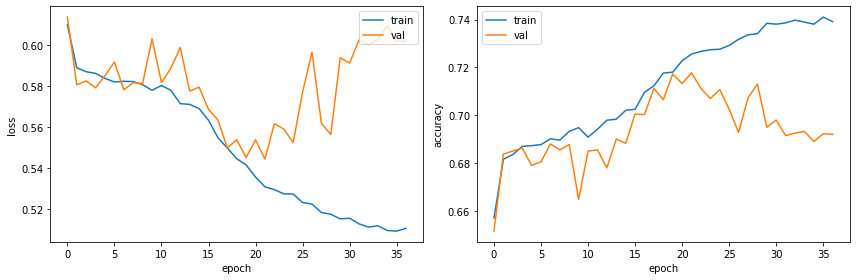

In [13]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()